In [30]:
#importando os pacotes
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick
import yfinance as yf

In [31]:
yf.pdr_override()
lista_acoes = ['BBAS3.SA', 'ITUB4.SA', 'VALE3.SA', 'PETR4.SA']
precos = pdr.get_data_yahoo(lista_acoes, dt.date(2015, 1, 1), dt.date(2022, 12, 31))['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [32]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna()
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

In [33]:
#Simulando 100.000 carteiras, utilizando o índice de sharpe de cada uma e guardando o peso dos ativos
numero_carteiras = 100000
vetor_retornos_esperados = np.zeros(numero_carteiras)
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
                        
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos)
    tabela_pesos[k, :] = pesos
    vetor_retornos_esperados[k]=np.sum(media_retornos*pesos*252)
    vetor_volatilidades_esperadas[k]=np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))
    vetor_sharpe[k]=vetor_retornos_esperados[k]/vetor_volatilidades_esperadas[k]

In [34]:
#Encontrando os pesos por ativo, com o comando
posicao_sharpe_maximo = vetor_sharpe.argmax()
pesos_otimos = tabela_pesos[posicao_sharpe_maximo, :]
pesos_otimos = [str((peso*100).round(2)) + "%" for peso in pesos_otimos]

for i, acao in enumerate(lista_acoes):
    print(f'Peso {acao}: {pesos_otimos[i]}')

Peso BBAS3.SA: 0.6%
Peso ITUB4.SA: 1.08%
Peso VALE3.SA: 35.24%
Peso PETR4.SA: 63.09%


In [35]:
#Plotando o vetor fronteira eficiente
vetor_retornos_esperados_arit = np.exp(vetor_retornos_esperados) - 1
eixo_y_fronteira_eficiente = np.linspace(vetor_retornos_esperados_arit.min(), vetor_retornos_esperados_arit.max(), 50)

In [36]:
#Criando as funções das linhas de otimização
def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos*peso_teste)*252
    retorno = np.exp(retorno) - 1
    return retorno

def checando_soma_pesos(peso_teste):
    return np.sum(peso_teste) - 1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))
    return vol

In [37]:
#utilizando as funções e parâmetros adicionais para criar o eixo X e buscando a melhor vol por retorno
peso_inicial = [1/len(lista_acoes)]*len(lista_acoes)
limites = tuple([(0,1) for ativo in lista_acoes])
eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    restricoes = ({'type': 'eq', 'fun':checando_soma_pesos},
                 {'type': 'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method='SLSQP', bounds=limites, constraints=restricoes)
    
    eixo_x_fronteira_eficiente.append(result['fun'])

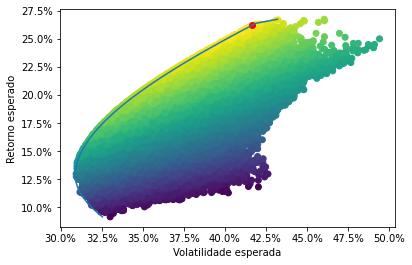

In [38]:
#Agora podemos traçar o gráfico com as simulações, destacando a carteira com o melhor índice de sharpe e traçando a fronteira eficiente
fig, ax = plt.subplots()
ax.scatter(vetor_volatilidades_esperadas, vetor_retornos_esperados_arit, c = vetor_sharpe)
plt.xlabel("Volatilidade esperada")
plt.ylabel("Retorno esperado")
ax.scatter(vetor_volatilidades_esperadas[posicao_sharpe_maximo],
          vetor_retornos_esperados_arit[posicao_sharpe_maximo], c='red')
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()